In [373]:
import os
import re
import sklearn
import numpy as np
import pandas as pd
from wombat.engine import ml_model
from wombat.engine import parse_input_description as parse_title
from wombat.models import Item
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.externals import joblib
from sklearn.ensemble import RandomForestRegressor
from wombat.models import dbsession, engine, ItemType, ItemAdjective
from sklearn.metrics import mean_absolute_error
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (20,12)

# suppress pandas warning about operations on copies of dfs
pd.options.mode.chained_assignment = None

In [378]:
df = ml_model.canonical_df
df = df.loc[(df['item_type'] == 'dresses') & (df['rent_per_week'] < 100)]
#df = df.loc[(df['item_type'] == 'dresses') & (df['rent_per_week'] < 100) & (df['rent_per_week'] > 100)]
df = df.loc[df.isnull().any(axis=1) == False]

# split data into train and test group
df['is_train'] = np.random.uniform(0, 1, len(df)) <= .75

# copy of train before we delete the 'rent_per_week' and 'title' field. We want title 
# we will need these things before we make dummy variables
df_full_training = df[df['is_train']==True]
df_full_test = df[df['is_train']==False]

# get one-hot columns for brands 
dummy_brands = pd.get_dummies(df['brand'])
df = pd.concat([df, dummy_brands], axis = 1)
df = df.drop('brand', axis = 1)

# get one-hot columns for item_types
dummified_items = pd.get_dummies(df['item_type'])
#df = pd.concat([df, dummified_items], axis = 1)
df = df.drop(['item_type'], axis = 1)
df.shape

(4248, 1265)

In [379]:
# get list of adjective features form database
#features_adj = [f.name for f in dbsession.query(ItemAdjective).all()]
item_types   = [item.name for item in dbsession.query(ItemType).all()]

features_adj = ['tube', 'sheath', 'blouson', 'tunic', 'pencil', 'asymmetric', 'trench', 'bandage', 'high-low', 'empire',
               'bodycon', 'skater', 'maxi', 'midi', 'mini', 'kaftan', 'shirt', 'off shoulder',
               'sweater', 'tie', 'peplum', 'party', 'backless', 'fringe', 'pop', 'baby', 'a-line', 'layered', 
                'lace-up', 'denim', 'dungaree', 'pinafore', 'cape', 'fit', 'flare', 'shift', 'slit',
                'spaghetti', 't-shirt', 'tulle', 'tuxedo', 'tweed', 'wrap', 'lace', 'cocktail', 'gown', 'runway']

#tokenized_titles = []
#for title in df['title']:
#    parse_title.create_one_hot_row_adj(title, features_adj)
#    tokenized_titles.append(parse_title.create_one_hot_row_adj(title, features_adj))
#df_adj = pd.DataFrame(tokenized_titles, columns = features_adj, index = df.index.values)

tokenized_titles = []
for text_array in df[['title', 'description']].values:
    try:
        text = ' '.join(text_array)
    except TypeError:
        text = title
    tokenized_titles.append(parse_title.create_one_hot_row_adj(text, features_adj))
df_adj = pd.DataFrame(tokenized_titles, columns = features_adj, index = df.index.values)

In [380]:
print(df.shape)
print(df_adj.shape)
df_w_adj = pd.concat([df, df_adj], axis = 1)
print(df_w_adj.shape)

(4248, 1265)
(4248, 47)
(4248, 1312)


In [363]:
df_w_adj.iloc[[4]]

,title,cost,rent_per_week,description,is_train,Narciso Rodriguez,3.1 Phillip Lim,ACE,ALEXANDER MCQUEEN,Adrianna Pappel,...,spaghetti,t-shirt,tulle,tuxedo,tweed,wrap,lace,cocktail,gown,runway
276,Zoya Suede Dress,1210.0,150.0,"1 dress, 2 ways! You can wear this beauty two ways with the v-neck option or the high neck option.",True,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [364]:
#print(df.loc[df.isnull().any(axis=1) == True])
#print(df.shape)
#print(df_adj.shape)
#print(df_adj.index)
#df = df.reset_index()
df_w_adj = pd.concat([df, df_adj], axis = 1)
df_w_adj.reset_index()
#print(df_w_adj.shape)
df_w_adj.iloc[3]

#print(df_adj.loc[df_adj.isnull().any(axis=1) == True])
#print(df_w_adj.loc[df_w_adj.isnull().any(axis=1) == True])
#print(df_w_adj.iloc[2])
#print(df_w_adj.loc[df_w_adj.isnull().any(axis=1) == True])

title                 Satin-Crepe Midi Dress                                                                                                                                                                                                                                                                                                                  
cost                  1495                                                                                                                                                                                                                                                                                                                                    
rent_per_week         120                                                                                                                                                                                                                                                                                 

In [365]:
df_w_adj

,title,cost,rent_per_week,description,is_train,Narciso Rodriguez,3.1 Phillip Lim,ACE,ALEXANDER MCQUEEN,Adrianna Pappel,...,spaghetti,t-shirt,tulle,tuxedo,tweed,wrap,lace,cocktail,gown,runway
40,Gown,1250.00,110.0,Elegant Navy blue silk gown,False,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
43,dress,6100.00,360.0,Dolce & Gabbana runway dress,True,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
49,Scoop Neck Fit and Flare,4025.00,160.0,"Go ultra glamorous in this gorgeous Alaia dress! Perfect for cocktail hour, this lovely fit-n-flare piece is sure to offer a luxurious and flexible wear. A unique square neckline provides a flirty detail along with a fabulous knit design throughout. Pair with pumps or go more casual with flats, either way, you'll be turning heads all night long! This dress features a fitted waist and flared skirt and intricate detailing throughout the piece. Sleeveless. Round neckline. Concealed back zip fastening. Fits true to size. \n\nDress is in white - silver is just for image reference (same dress different color)",True,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
174,Satin-Crepe Midi Dress,1495.00,120.0,"Have a ball in the city of stars or wherever you are—this Jason Wu can be seen on Emma Stone in the final scenes of La La Land! \nMade of emerald green satin crepe, the slip dress reads as a size 8, but fits more like a 6. Built-in structure insures you won't have to worry about finding a bra to work with the daring open back.",False,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
276,Zoya Suede Dress,1210.00,150.0,"1 dress, 2 ways! You can wear this beauty two ways with the v-neck option or the high neck option.",True,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
277,Open Shoulder Beaded Dress,1135.00,130.0,Perfect summer mini dress with the shoulder cutout trend + small tassels and lace like ruffle details.,True,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
296,Red Dress,1200.00,200.0,Red dress,True,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
340,Pearl studded knit dress,3368.00,322.0,A lovely comfortable dress that will make you stand out!,True,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
375,White Gown,780.00,112.0,White formal dress that can we worn as a wedding gown or formal dress with train tucked up.,True,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
401,Dreamer,1690.00,130.0,"Snug, body conscious fit. Bandage style and looser fit on the bottom.",True,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [381]:
final_df = df_w_adj
features = final_df.columns.drop(['rent_per_week', 'title', 'cost', 'is_train', 'description']) # just column names
train, test = final_df[final_df['is_train']==True], final_df[final_df['is_train']==False]

In [382]:
#clf = svm.SVR() # didn't work. Predicted 43 for everything
reg = RandomForestRegressor(n_jobs=2, n_estimators=15)
#clf.fit(train[features], train['rent_per_week'])
#rfr_predicted = clf.predict(test[features])
#reg = linear_model.LinearRegression() # total crap
#reg = linear_model.Ridge(alpha = .5) # comparable to rfr
#reg = linear_model.RidgeCV(alphas=[0.1, 1.0, 10.0]) # comparable to rfr 
#reg = linear_model.Lasso(alpha = 0.1)
#reg = linear_model.ElasticNet(alpha=0.1) # comparable to rfr 
#reg = linear_model.RANSACRegressor(linear_model.LinearRegression()) # slow, did not finish, uses lots of cpu
#reg = linear_model.TheilSenRegressor() # slow, did not finish, uses lots of cpu
#reg = linear_model.HuberRegressor() # slow, did not finish, uses lots of cpu

In [383]:
reg.fit(train[features], train['rent_per_week'])
predicted = reg.predict(test[features])

model_dir = '/home/patrick/Dropbox/insight/wombat/wombat/engine/stat_model_pickles'
model_path = os.path.join(model_dir, 'rfr_v0.1_no_adj.pkl')
#joblib.dump(reg, model_path)
#call this with: clf = joblib.load('huber_v0.1.pkl')
#rfr_predicted
#stopping_value = np.minimum(np.maximum(test['rent_per_week'].values), np.maximum(rfr_predicted))

Slope of regression line for obs v pred:  [ 0.27304152]
Variance score: 0.21
mean_absolute_error: 10.798336357539469
Length of df_full_test: 1075


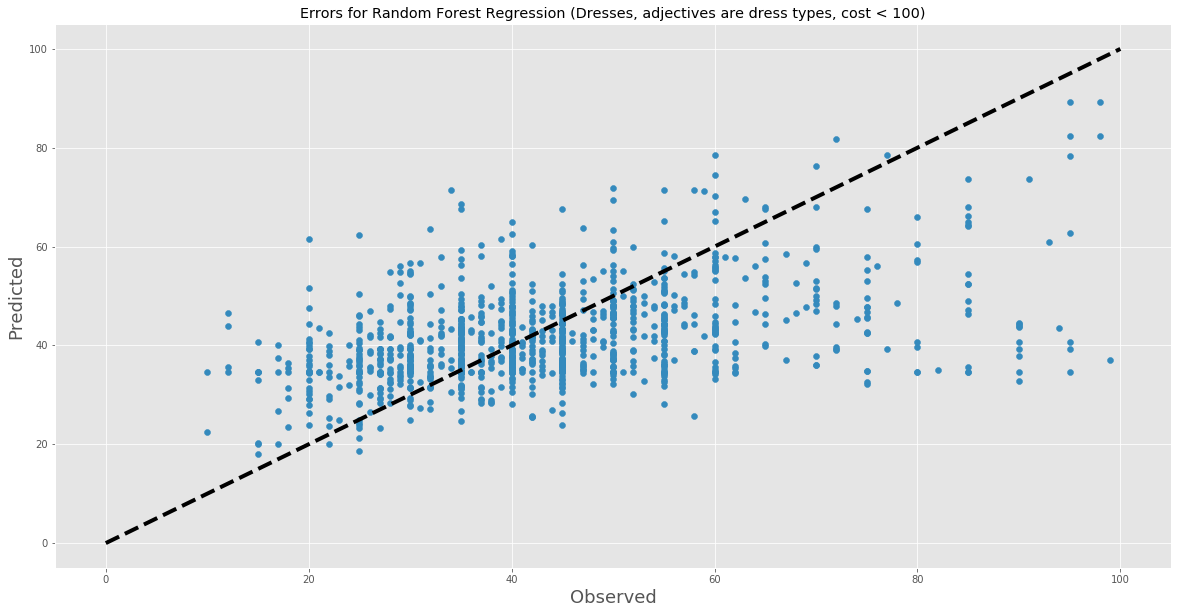

In [394]:
# Create linear regression object for predicted vs measured
reg = linear_model.LinearRegression()

x = test['rent_per_week'].values.reshape(-1,1)
y = np.array(predicted)

# Train the model using the training sets
reg.fit(x, y)
# The coefficients
print('Slope of regression line for obs v pred: ', reg.coef_)

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % reg.score(x, y))

print("mean_absolute_error: {}".format(mean_absolute_error(x, y)))

# Plot outputs
fig, ax = plt.subplots(figsize=(20, 10))
ax.scatter(x = test['rent_per_week'], y = predicted, color = '#348abd')
#stopping_value = np.minimum(np.maximum(test['rent_per_week'].values), np.maximum(rfr_predicted))
stopping_value = 100
ax.plot([0, stopping_value], [0, stopping_value], 'k--', lw=4)
ax.set_title('Errors for Random Forest Regression (Dresses, adjectives are dress types, cost < 100)')
ax.set_xlabel('Observed', fontsize=18)
ax.set_ylabel('Predicted', fontsize=18)
#ax.plot(x, reg.predict(x), 'k--', color='blue', linewidth=3)

#ax.text(0, 70, 'Coefficients: {}'.format(reg.coef_), style='italic', fontsize=16,
       # bbox={'facecolor':'blue', 'alpha':0.2, 'pad':10})
#ax.text(0,500, "Mean squared error: %.2f"
      #% np.mean((reg.predict(x) - y) ** 2), style='italic', fontsize=16,
      #  bbox={'facecolor':'blue', 'alpha':0.2, 'pad':10})
#ax.text(20, 100, 'Variance score: %.2f' % reg.score(x, y), style='italic', fontsize=16,
     #   bbox={'facecolor':'blue', 'alpha':0.2, 'pad':10})

x = test['rent_per_week']
df_full_test['predicted_rent'] = predicted
#df_full_test['error'] = df_full_test[['rent_per_week', 'predicted_rent']].subtract(axis=1)
df_full_test['error'] = df_full_test['rent_per_week'] - df_full_test['predicted_rent']
print("Length of df_full_test: {}".format(len(df_full_test)))
#df_full_test['error'] = df_full_test['error'].abs()
df_error = df_full_test.loc[df_full_test['error']>0][['brand', 'item_type', 'title', 'error', 'description']].sort_values('error', ascending = 0)
#reg.score(x, y)
#print("Length of df_error: {}".format(len(df_error)))

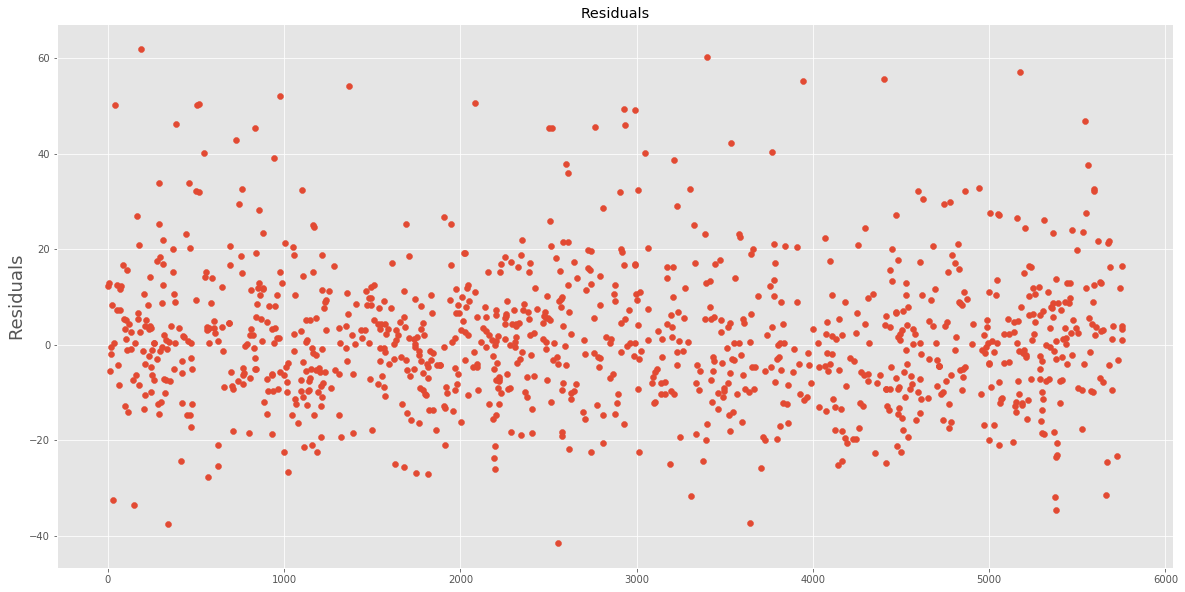

In [401]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.scatter(df_full_test['error'].index, df_full_test['error'].values)
ax.set_title('Residuals')
ax.set_ylabel('Residuals', fontsize=18)

In [389]:
pd.set_option('display.max_colwidth', -1)

#d_errors = df_error.sort_values('error', ascending=False)
binwidth = 50
bins = list(range(0, 1000 + binwidth, binwidth))
l = []
#for i in bins:
#    y = len(d[d['error'] < i+1]) & (d[d['error'] >= i]))
#    x = i
#    l.append((x,y))
#lower = 0
#upper = 50
#d_errors = df_error.sort_values('error', ascending=True)
#num_high_errors = d_errors[(d_errors['error'] > 30) & (d_errors['error'] < 1000)]
#len(num_high_errors)
#num_low_errors = d_errors[(d_errors['error'] > 0) & (d_errors['error'] < 10)]
#print(len(num_low_errors)/len(num_high_errors))
#print(len(num_low_errors)/len(d_errors))
#print(len(num_low_errors))
d_errors = df_full_test
num_low_errors = d_errors[(d_errors['error'] > 0) & (d_errors['error'] < 20)]
num_high_errors = d_errors[(d_errors['error'] > 20) & (d_errors['error'] < 1000)]
print(len(num_low_errors))
print(len(num_low_errors)/len(d_errors))
print(len(num_high_errors))
d_errors = df_full_test.sort_values('error', ascending=False)
d_errors

923
0.8586046511627907
149


,brand,item_type,title,cost,rent_per_week,description,is_train,predicted_rent,error
190,piazza. sempione,dresses,Silk floral dress,995.00,99.0,"Gorgeous silk dress...perfect for cocktail, shower, lunch",False,37.000000,62.000000
3397,Céline,dresses,Tangerine Colorblocked Dress,900.00,95.0,Tangerine and grey coloblocked dress from Celine. Composition: 100% Silk.,False,34.666667,60.333333
5177,Duchess,dresses,Double layer georgette dress with spaghetti straps,800.00,90.0,"100% Georgette viscose, bias cut.\nHem in back is 2 inches longer in the back.",False,32.866667,57.133333
4404,HERVE LEGER,dresses,SLUMBER,1200.00,95.0,"Flattering angled panels shape the low-cut bodice of a curve-hugging dress in a bright, substantial knit. A tonal strap reaches across the back shoulders, creating a slip-proof fit above the beautifully bare back.",False,39.266667,55.733333
3943,Alexander McQueen,dresses,Blue Kaleidoscope,990.00,90.0,Blue kaleidoscope dress from Alexander McQueen,False,34.666667,55.333333
1367,Milly,dresses,White Mirage Silk Organza Gown,825.00,95.0,Sleeveless sheer yoke with v-neck + pleating at skirt. This is a great dress to wear to a black tie formal event.\nComposition: 100% Silk,False,40.755556,54.244444
975,Burberry,dresses,Teal Ruffle Short Sleeve Midi Dress,2195.00,90.0,"This beautiful Burberry dress features layers of ruffles and ruching. A brought in waist forms a flattering shape. Composition: 100% Silk. Model:5'8"", B:33, W:24.5, H:35.",False,37.866667,52.133333
2085,Preen,dresses,Geometric Dress,1200.00,90.0,Geometric fit dress with mesh detailing and draping skirt. Pair with your favorite lipstick and be sure to be a show stopper! Composition: 100% Silk.,False,39.266667,50.733333
518,P.A.R.O.S.H.,dresses,'Pantera' Dress,689.93,94.0,"Pink 'Pantera' dress from P.A.R.O.S.H. features a robe tie, a cinched back, and a long length. \nComposition:Polyester 100%.",False,43.533333,50.466667
42,Macy's,dresses,Prom dress,300.00,85.0,Only worn once. Beautiful shiny sequins. One strap. 100% polyester. Style-Estilo. Cut-Corte. Zipper back.,False,34.666667,50.333333


In [371]:
df_error[df_error['brand']=='Yves Saint Laurent']

NameError: name 'df_error' is not defined

In [ ]:
 # make plotly plot
import plotly.plotly as py
import plotly.graph_objs as go

brands = df_full_training['brand'].values
item_types = df_full_training['item_type'].values
titles = df_full_training['title'].values
labels = []
for i in list(range(0, len(brands))):
    labels.append("{}, {}, {}".format(brands[i], item_types[i], titles[i]))

data = [
    go.Scatter(
        x=test['rent_per_week'],
        y=rfr_predicted,
        mode='markers',
        text=labels
    )
]
layout = go.Layout(
    title='Measured vs Predicted outcomes using Random Forest model'
)
fig = go.Figure(data=data, layout=layout)
plot_url = py.plot(fig, filename='meas-v-pred-rfr-2017-06-12')

In [ ]:
from sklearn import linear_model
# Create linear regression object
reg = linear_model.LinearRegression()

x = test['rent_per_week'].values.reshape(-1,1)
y = np.array(rfr_predicted)

# Train the model using the training sets
reg.fit(x, y)
# The coefficients
print('Coefficients: \n', reg.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % np.mean((reg.predict(x) - y) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % reg.score(x, y))

# Plot outputs
plt.scatter(x, y,  color='black')
plt.plot(x, reg.predict(x), color='blue',
         linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()